In [1]:
filename = 'sample.csv'
output_filename = 'output.png'
target = {
#     operator: (marker, markersize, color)
    '帕拉斯': ('*', 48, 'red'),
    '其他':   ('o', 24, 'yellow')
}

# marker reference
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/marker_reference.html

In [2]:
# Common
def contains_chinese(s):
    for c in s:
        if '\u4e00' <= c <= '\u9fa5':
            return True
    return False

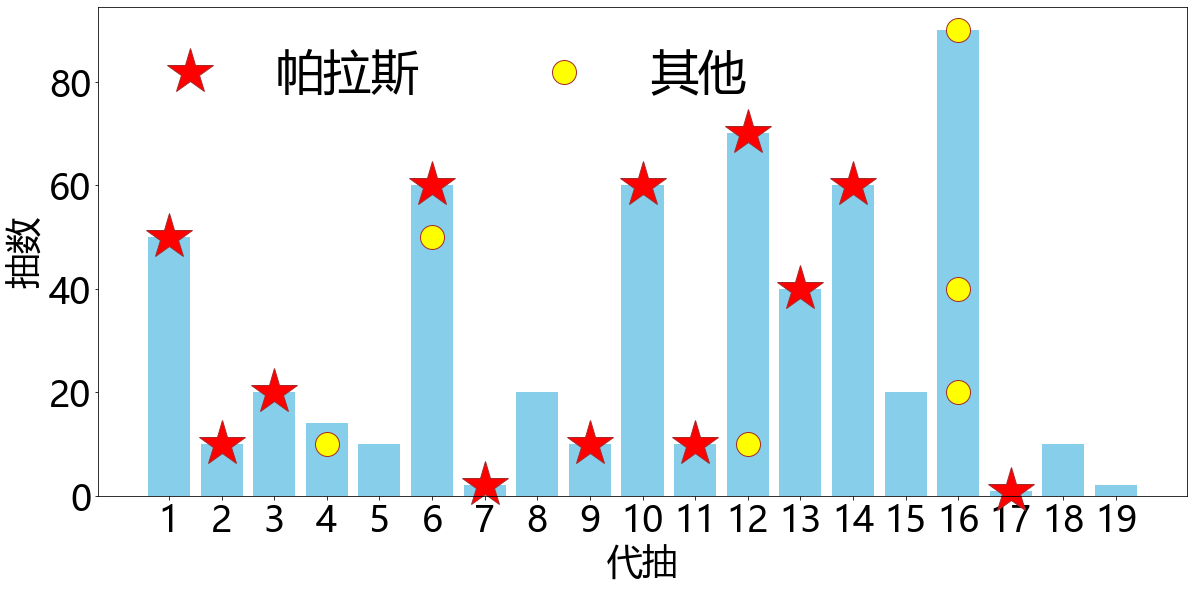

In [3]:
# Plot figure

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus']

def parse_file(filename):
    index = {operator: [] for operator in target}
    
    summed_lines = []
    with open(filename, encoding='utf-8-sig') as f:
        for lineno, line in enumerate(f.readlines()):
            parts = line.split(',')
            accumulated = 0
            for part in parts:
                if part.strip().isnumeric():
                    accumulated += int(part)
                elif part in target:
                    index[part].append((lineno, accumulated))
                elif contains_chinese(part):
                    index['其他'].append((lineno, accumulated))
            summed_lines.append(accumulated)
    return index, summed_lines

index, summed_lines = parse_file(filename)
x = [i for i in range(len(summed_lines))]
y = summed_lines

x_ticks = [i for i in range(len(summed_lines))]
x_ticklabels = [str(i + 1) for i in range(len(summed_lines))]

fig, ax = plt.subplots(figsize=(19.5, 9))
ax.bar(x, y, color='skyblue')

def plot_6start(label, series, marker, markersize, color):
    a = [x for x, y in series]
    b = [y for x, y in series]
    ax.plot(a, b, label=label, linewidth=0, marker=marker, markersize=markersize, markeredgecolor='brown', color=color, clip_on=False)

for operator in index:
    plot_6start(operator, index[operator], *(target[operator]))

plt.legend(loc='upper left', fontsize=48, ncol=2, frameon=False)
    
plt.xlabel("代抽", fontsize=36)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels)
ax.tick_params(axis='both', labelsize=36)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel("抽数", fontsize=36)
# ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

fig.savefig(output_filename, transparent=True)

In [4]:
# Collect basic statistics

def analyze_statistics(filename):
    pass